In [29]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from underthesea import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [23]:
data_df = pd.read_csv('data/vn_news_223_tdlfr.csv', encoding = 'utf-8')
file = open('data/vietnamese-stopwords.txt','r', encoding = 'utf-8')
stopWords = file.read().split('\n')
file.close()

In [24]:
data_df

text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

# Khám phá dữ liệu

In [31]:
# Xem các mẫu dữ liệu:
data_df.sample(5)

text  \
38                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           cảm giác như trục quay trái đất sắp gãy khi xem loạt ảnh không thể không gào thét này bạn sẽ thấy bứt rứt  khó chịu  đau đớn thậm chí là tức nổ đom đóm mắt nếu một ngày rơi vào hoàn cảnh như vậy  tôi khuyên bạn chân thành một câu  đừng để những thứ cối chày đó ảnh hưởng đến cảm xúc của mình  vì nó đang muốn mình già đi  xấu xí đi  thà không cắt còn bảo toàn được cái kéo chứ giờ thì  vật cuối cùng để liên lạc với người yêu cũng bị hỏng cảm giác như khó thở  bứt rứt đầy bất lực tại sao chúng mày lại chống lại tao thế kia  tan nát đời mông   may chỉ hỏng cái ghế  hỏng bộ ấm chén thì còn nhục ấy đánh rễ đánh cả cụm tấm lưng này mà mang đi tán gái  em không đổ cũng phải đổ tao xin mày  nhà tao con một mày ơi  bằng chứng xác thực của chân dài đến nách   
138                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [36]:
# Xem thông tin data:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    223 non-null    object
 1   domain  223 non-null    object
 2   label   223 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.4+ KB


In [53]:
# Ý nghĩa các cột: text: nội dung tin tức, domain: đường dẫn đến trang chứa tin tức, label: nhãn phân loại giả hay thật

In [56]:
# Dữ liệu được thu thập từ nguồn nào nhiều nhất?
data_df['domain'].value_counts()
# --> Dữ liệu được thu thập nhiều nhất từ vnexpress và tinvn.

vnexpress.net              73
tinvn.info                 68
dantri.com.vn              14
thethao.tuoitre.vn         10
news.zing.vn                6
thoibao.today               6
tintucqpvn.net              5
tuoitre.vn                  5
thanhnien.vn                5
phapluat.news               3
kinhdoanh.vnexpress.net     3
doisong.vnexpress.net       2
thegioitre.vn               2
thoibao.de                  2
giaitri.vnexpress.net       2
giadinhtiepthi.com          2
www.ipick.vn                2
dulich.vnexpress.net        1
baonuocmy.com               1
haiduong.tintuc.vn          1
baoangiang.com.vn           1
autoxe.net                  1
suckhoe.vnexpress.net       1
sorry.vn                    1
sohoa.vnexpress.net         1
https://news.zing.vn        1
www.gioitreviet.net         1
laodong.vn                  1
binhluan.biz                1
www.vietgiaitri.com/        1
Name: domain, dtype: int64

# Tiền xử lý dữ liệu

In [35]:
# Có bị lặp các dòng không?
duplicated_count=data_df.index.duplicated().sum()
duplicated_count
# --> Các dòng không bị lặp

0

In [43]:
# Dữ liệu có bị thiếu không?
laked_text=data_df['text'].isnull().sum()
laked_domain=data_df['domain'].isnull().sum()
laked_label=data_df['label'].isnull().sum()
print(laked_text, laked_domain, laked_label)
# --> Dữ liệu không bị thiếu

0 0 0


In [45]:
# Các cột có kiểu dữ liệu gì? Có phù hợp không?
data_df.dtypes

text      object
domain    object
label      int64
dtype: object

In [47]:
# Ta thấy có các cột có kiểu dữ liệu object, vậy nó là gì?
def open_object_dtype(s):
    dtypes = set()
    s=s.apply(type)
    dtypes.update(s.unique().tolist())
    return dtypes

In [49]:
open_object_dtype(data_df['text'])

{str}

In [51]:
open_object_dtype(data_df['domain'])

{str}

In [58]:
# --> Nhìn chung các cột có kiểu dữ liệu khá phù hợp, không cần chỉnh sửa gì thêm

0    55.156951
1    44.843049
Name: label, dtype: float64

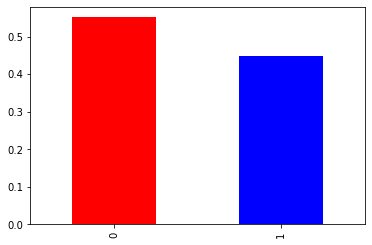

In [61]:
# Phân bố các class có chênh lệch không?
data_df.label.value_counts(normalize=True).plot(kind="bar", color=["red", "blue"])
data_df['label'].value_counts(normalize=True) * 100
# --> Tỉ lệ giữa lớp thật và giả là tương đối ngang nhau, sự chênh lệch không quá lớn

In [40]:
# Loại bỏ các đường dẫn, các dấu câu, ký tự \n và chuyển về lowercase
def wordopt(text):
    text = text.lower()
    text = re.sub('https?:\/\/.*[\r\n]*', ' ', text)
    text = re.sub('[^\w\s]',' ',text) 
    text = re.sub('\n', ' ', text)
    return text

In [41]:
data_df["text"]=data_df["text"].apply(wordopt)

In [42]:
data_df

text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

# Tokenizer

In [10]:
def tokenize(sentence):
    return word_tokenize(sentence, format = 'word')

In [27]:
vectorizer = CountVectorizer(
    stop_words = stopWords,
    tokenizer = tokenize
)
print(vectorizer)

CountVectorizer(stop_words=['a lô', 'a ha', 'ai', 'ai ai', 'ai nấy', 'ai đó',
                            'alô', 'amen', 'anh', 'anh ấy', 'ba', 'ba ba',
                            'ba bản', 'ba cùng', 'ba họ', 'ba ngày', 'ba ngôi',
                            'ba tăng', 'bao giờ', 'bao lâu', 'bao nhiêu',
                            'bao nả', 'bay biến', 'biết', 'biết bao',
                            'biết bao nhiêu', 'biết chắc', 'biết chừng nào',
                            'biết mình', 'biết mấy', ...],
                tokenizer=<function tokenize at 0x00000263BFED7820>)


In [28]:
X = data_df["text"]
y = data_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
Xv_train = vectorizer.fit_transform(X_train)
Xv_test = vectorizer.transform(X_test)

#save model vectorizer
joblib.dump(vectorizer, 'models/vectorizer.joblib')

D:\Anaconda\envs\min_ds-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'bao', 'bất', 'bất ý', 'bập', 'chi', 'chí', 'chót', 'chưng', 'chẳng', 'chết', 'chừng', 'coi', 'câu', 'cóc', 'cạnh', 'cảm', 'cật', 'cắt', 'cực', 'da', 'giời', 'hiện', 'hầu', 'hẳn', 'khô', 'kì', 'kỳ', 'lí', 'lô', 'lý', 'lẽ', 'lị', 'mày', 'mòi', 'mấy', 'mẹ', 'ngõ', 'nhiên', 'nhược', 'nhỡ', 'nỗi', 'phương', 'sợ', 'sức', 'thiên địa', 'thành', 'thái', 'thảo', 'thảy', 'thử', 'thực', 'tiếp', 'tiệt', 'trời đất', 'tuốt', 'tuồn tuột', 'tuồng', 'tàn', 'tàn tán', 'tán', 'tề', 'tỏ', 'tức', 'vung', 'ví', 'vô', 'vạn', 'vả', 'vẻ', 'xuất', 'xảy', 'xửa', 'âu', 'ô', 'ôi', 'đi', 'đành', 'đánh', 'đáo', 'đùng', 'đạch', 'đại', 'ối'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  (0, 3378)	3
  (0, 6910)	1
  (0, 577)	1
  (0, 2051)	2
  (0, 612)	4
  (0, 6413)	11
  (0, 1161)	2
  (0, 6735)	4
  (0, 2261)	8
  (0, 5767)	2
  (0, 4057)	4
  (0, 783)	4
  (0, 656)	2
  (0, 4801)	1
  (0, 1958)	2
  (0, 2250)	1
  (0, 1412)	1
  (0, 4036)	1
  (0, 2586)	1
  (0, 6476)	1
  (0, 3738)	1
  (0, 6330)	1
  (0, 5417)	2
  (0, 1232)	1
  (0, 6980)	2
  :	:
  (166, 7051)	1
  (166, 548)	1
  (166, 4607)	1
  (166, 3880)	1
  (166, 2522)	1
  (166, 5864)	1
  (166, 542)	1
  (166, 5542)	1
  (166, 5627)	1
  (166, 2143)	2
  (166, 7005)	1
  (166, 3112)	5
  (166, 4765)	1
  (166, 1989)	1
  (166, 6088)	1
  (166, 4857)	1
  (166, 1605)	1
  (166, 2500)	1
  (166, 5359)	1
  (166, 6043)	1
  (166, 4359)	1
  (166, 5185)	1
  (166, 5244)	1
  (166, 1880)	1
  (166, 4137)	2


In [17]:
#Decision Tree
DT = DecisionTreeClassifier()
DT.fit(Xv_train,y_train)
pred_dt = DT.predict(Xv_test)
print(DT.score(Xv_test, y_test))
#save model Decision Tree
joblib.dump(DT, 'models/DT_model.joblib')

DecisionTreeClassifier()

In [20]:
#Naive Bayes
NB = MultinomialNB()
NB.fit(Xv_train,y_train)
pred_nb = DT.predict(Xv_test)
print(NB.score(Xv_test, y_test))
#save model Naive Bayes
joblib.dump(NB, 'models/NB_model.joblib')

0.9107142857142857


['models/NB_model.joblib']